## Building a model to run on Warcarft 2 tile data set

In [15]:
import time
import random
# import pyepo
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from torch_Dijkstra import Dijkstra
# fix random seed
random.seed(135)
np.random.seed(135)
torch.manual_seed(135)

In [16]:
warcraft_data_folder = './warcraft_data/'
tmaps_train = np.load(warcraft_data_folder + "12x12/train_maps.npy")
tmaps_val = np.load(warcraft_data_folder + "12x12/val_maps.npy")
tmaps_test = np.load(warcraft_data_folder + "12x12/test_maps.npy")

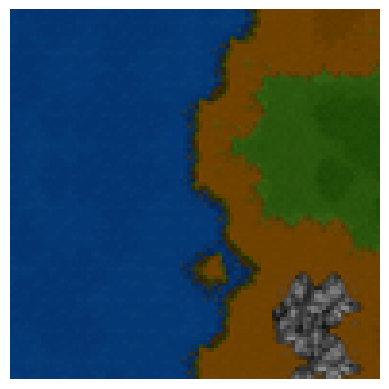

In [17]:
plt.axis("off")
plt.imshow(tmaps_train[1])
plt.show()

In [18]:
costs_train = np.load(warcraft_data_folder + "12x12/train_vertex_weights.npy")
costs_val = np.load(warcraft_data_folder + "12x12/val_vertex_weights.npy")
costs_test = np.load(warcraft_data_folder + "12x12/test_vertex_weights.npy")

In [19]:
paths_train = np.load(warcraft_data_folder + "12x12/train_shortest_paths.npy")
paths_val = np.load(warcraft_data_folder + "12x12/val_shortest_paths.npy")
paths_test = np.load(warcraft_data_folder + "12x12/test_shortest_paths.npy")

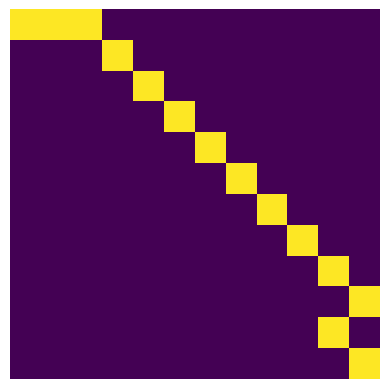

In [20]:
plt.axis("off")
plt.imshow(paths_train[1])
plt.show()

In [37]:
 # Construct vertices. Note each vertex is at the middle of the square.
k = 12
Vertices = []
for i in range(k):
    for j in range(k):
        Vertices.append((i+0.5, j+0.5))

num_vertices = len(Vertices)
# Construct edges.
Edges = []
for i, v1 in enumerate(Vertices):
    for j, v2 in enumerate(Vertices):
        norm_squared = (v1[0] - v2[0])**2 + (v1[1] - v2[1])**2
        if 0 < norm_squared < 2.01 and i < j:
            Edges.append((v1, v2))
            Edges.append((v2, v1)) # have to double edges to allow for travel both ways

num_edges = len(Edges)

In [38]:
print(Edges)

[((0.5, 0.5), (0.5, 1.5)), ((0.5, 1.5), (0.5, 0.5)), ((0.5, 0.5), (1.5, 0.5)), ((1.5, 0.5), (0.5, 0.5)), ((0.5, 0.5), (1.5, 1.5)), ((1.5, 1.5), (0.5, 0.5)), ((0.5, 1.5), (0.5, 2.5)), ((0.5, 2.5), (0.5, 1.5)), ((0.5, 1.5), (1.5, 0.5)), ((1.5, 0.5), (0.5, 1.5)), ((0.5, 1.5), (1.5, 1.5)), ((1.5, 1.5), (0.5, 1.5)), ((0.5, 1.5), (1.5, 2.5)), ((1.5, 2.5), (0.5, 1.5)), ((0.5, 2.5), (0.5, 3.5)), ((0.5, 3.5), (0.5, 2.5)), ((0.5, 2.5), (1.5, 1.5)), ((1.5, 1.5), (0.5, 2.5)), ((0.5, 2.5), (1.5, 2.5)), ((1.5, 2.5), (0.5, 2.5)), ((0.5, 2.5), (1.5, 3.5)), ((1.5, 3.5), (0.5, 2.5)), ((0.5, 3.5), (0.5, 4.5)), ((0.5, 4.5), (0.5, 3.5)), ((0.5, 3.5), (1.5, 2.5)), ((1.5, 2.5), (0.5, 3.5)), ((0.5, 3.5), (1.5, 3.5)), ((1.5, 3.5), (0.5, 3.5)), ((0.5, 3.5), (1.5, 4.5)), ((1.5, 4.5), (0.5, 3.5)), ((0.5, 4.5), (0.5, 5.5)), ((0.5, 5.5), (0.5, 4.5)), ((0.5, 4.5), (1.5, 3.5)), ((1.5, 3.5), (0.5, 4.5)), ((0.5, 4.5), (1.5, 4.5)), ((1.5, 4.5), (0.5, 4.5)), ((0.5, 4.5), (1.5, 5.5)), ((1.5, 5.5), (0.5, 4.5)), ((0.5, 5.5)

In [23]:
## Small utility for rounding coordinates of points
def RoundCoords(vertex_name):
  vertex_coord = [int(vertex_name[0]), int(vertex_name[1])]
  return vertex_coord

In [24]:
## Vertex Edge incidence matrix
A = torch.zeros((len(Vertices), len(Edges)))
for j, e in enumerate(Edges):
    ind0 = Vertices.index(e[0])
    ind1 = Vertices.index(e[1])
    A[ind0,j] = -1.
    A[ind1,j] = +1.

## Create b vector necessary for LP approach to shortest path
b = torch.zeros(k**2)
b[0] = -1.0
b[-1] = 1.0

In [25]:
print(A[:,1])

tensor([ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.])


In [26]:
print(len(Vertices) == k**2)

True


In [27]:
## Utility for converting path in vertex format to edge list format
dijkstra = Dijkstra(euclidean_weight=True,four_neighbors=False)

In [28]:
Costs = 2 - paths_train[0]
print(Costs)
path_v, path_e = dijkstra.run_single(Costs,Gen_Data=True)
path_e.reverse() # reverse list as output starts from bottom right corner

[[1 2 2 2 2 2 2 2 2 2 2 2]
 [1 2 2 2 2 2 2 2 2 2 2 2]
 [2 1 2 2 2 2 2 2 2 2 2 2]
 [2 2 1 2 2 2 2 2 2 2 2 2]
 [2 2 2 1 2 2 2 2 2 2 2 2]
 [2 2 2 2 1 2 2 2 2 2 2 2]
 [2 2 2 2 2 1 2 2 2 2 2 2]
 [2 2 2 2 2 1 2 2 2 2 2 2]
 [2 2 2 2 2 2 1 2 2 2 2 2]
 [2 2 2 2 2 2 2 1 2 2 2 2]
 [2 2 2 2 2 2 2 2 1 2 1 2]
 [2 2 2 2 2 2 2 2 2 1 2 1]]


In [29]:
print(path_e)

[(0.5, 0.5), (1.5, 0.5), (2.5, 1.5), (3.5, 2.5), (4.5, 3.5), (5.5, 4.5), (6.5, 5.5), (7.5, 5.5), (8.5, 6.5), (9.5, 7.5), (10.5, 8.5), (11.5, 9.5), (10.5, 10.5), (11.5, 11.5)]


In [30]:
# Encode edge description of shortest path as a vector
path_vec_e = torch.zeros(len(Edges))
for i in range(len(path_e)-1):
    path_vec_e[Edges.index((path_e[i], path_e[i+1]))] = 1

In [31]:
print(path_vec_e)

tensor([0., 0., 1.,  ..., 0., 0., 0.])


In [32]:
## Test 
# test the accuracy of the above by converting back to node map
## Utility for converting path in edge list format to node list format
def Edge_to_Node(path, Edge_list, m, device):
  node_map = torch.zeros((m,m), device=device)
  node_map[0,0] = 1.
  node_map[-1,-1] = 1.
  path_list = []
  for edge_num, edge_val in enumerate(path):
    if edge_val > 0:
      edge_name = Edge_list[edge_num]
      path_list.append(edge_name)
      node_0 = RoundCoords(edge_name[0])
      node_1 = RoundCoords(edge_name[1])
      node_map[node_0[0], node_0[1]] += edge_val
      node_map[node_1[0], node_1[1]] += edge_val
  return node_map/2

In [33]:
node_map = Edge_to_Node(path_vec_e, Edges, k, 'cpu')

In [34]:
print(node_map)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]])


In [35]:
print(paths_train[0])

[[1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 1]]


In [36]:
## TODO:
# Need to remember to scale edge lengths to account for diagonals.